In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import math

from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error, mean_absolute_percentage_error
from sklearn.linear_model import LinearRegression
from sklearn.neural_network import MLPClassifier
from sklearn.model_selection import KFold

from keras.models import Sequential
from keras.layers import Dense, LSTM, RNN, GRU, Dropout, Activation
from tensorflow.keras.datasets import imdb
from tensorflow.keras.layers import SimpleRNN, Embedding
from tensorflow.keras.preprocessing import sequence

from statsmodels.tsa.arima.model import ARIMA
from scipy.stats import skew, kurtosis

### Read data ###

In [2]:
df = pd.read_csv('./BTC-USD.csv')

In [3]:
df.head()

,Date,Open,High,Low,Close,Adj Close,Volume
0,2019-03-01,3853.757080,3907.795410,3851.692383,3859.583740,3859.583740,7661247975
1,2019-03-02,3855.318115,3874.607422,3832.127930,3864.415039,3864.415039,7578786076
2,2019-03-03,3862.266113,3875.483643,3836.905762,3847.175781,3847.175781,7253558152
3,2019-03-04,3845.091553,3867.381836,3733.749756,3761.557129,3761.557129,9029175788
4,2019-03-05,3759.832520,3903.916748,3745.183105,3896.375000,3896.375000,10174126415


In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1909 entries, 0 to 1908
Data columns (total 7 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   Date       1909 non-null   object 
 1   Open       1909 non-null   float64
 2   High       1909 non-null   float64
 3   Low        1909 non-null   float64
 4   Close      1909 non-null   float64
 5   Adj Close  1909 non-null   float64
 6   Volume     1909 non-null   int64  
dtypes: float64(5), int64(1), object(1)
memory usage: 104.5+ KB


In [5]:
df.shape

(1909, 7)

In [6]:
df['Date'] = pd.to_datetime(df['Date'])
df.reset_index(drop=True)
df.set_index('Date', inplace=True)

### Descriptive statistc ###

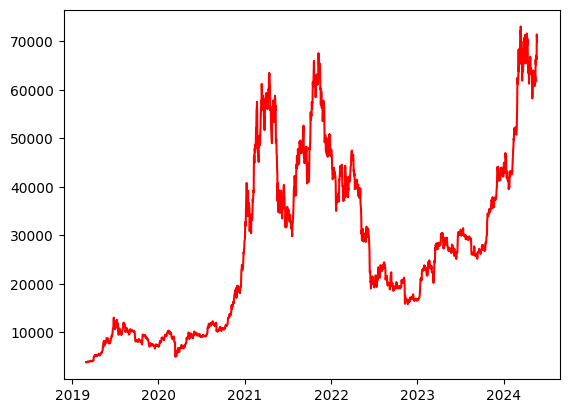

In [7]:
plt.figure()
plt.plot(df["Close"], color='red')
plt.show()

<Axes: >

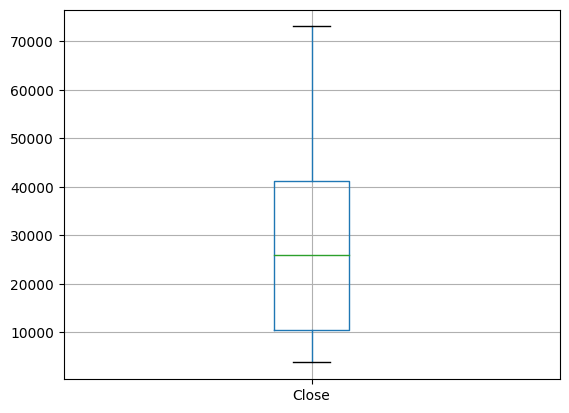

In [8]:
df.boxplot(column=['Close'])

In [9]:
column='Close'
summary = {
    'mean': df[column].mean(),
    'mode': df[column].mode()[0], 
    'std': df[column].std(),
    'var': df[column].var(),
    'kurtosis': kurtosis(df[column]),
    'skewness': skew(df[column]),
    'range': df[column].max() - df[column].min(),
    'min': df[column].min(),
    'max': df[column].max(),
    'sum': df[column].sum(),
    'count': df[column].count(),
    'median': df[column].median()
}

print(f"Summary statistics for column {column}:")
for stat, value in summary.items():
    print(f"{stat}: {value}")


Summary statistics for column Close:
mean: 27700.52769653222
mode: 3761.557129
std: 17708.57514402739
var: 313593633.6316647
kurtosis: -0.6948182249917778
skewness: 0.5713889457991368
range: 69321.942871
min: 3761.557129
max: 73083.5
sum: 52880307.37268001
count: 1909
median: 25868.798828


In [10]:
df['Close'].describe()

count     1909.000000
mean     27700.527697
std      17708.575144
min       3761.557129
25%      10410.126953
50%      25868.798828
75%      41143.929688
max      73083.500000
Name: Close, dtype: float64

### Preprocess data ###

In [11]:

df['Year'] = df.index.year
df['Month'] = df.index.month
df['Day'] = df.index.day

In [12]:
df.head()

,Open,High,Low,Close,Adj Close,Volume,Year,Month,Day
Date,,,,,,,,,
2019-03-01,3853.757080,3907.795410,3851.692383,3859.583740,3859.583740,7661247975,2019,3,1
2019-03-02,3855.318115,3874.607422,3832.127930,3864.415039,3864.415039,7578786076,2019,3,2
2019-03-03,3862.266113,3875.483643,3836.905762,3847.175781,3847.175781,7253558152,2019,3,3
2019-03-04,3845.091553,3867.381836,3733.749756,3761.557129,3761.557129,9029175788,2019,3,4
2019-03-05,3759.832520,3903.916748,3745.183105,3896.375000,3896.375000,10174126415,2019,3,5


In [13]:
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 1909 entries, 2019-03-01 to 2024-05-21
Data columns (total 9 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   Open       1909 non-null   float64
 1   High       1909 non-null   float64
 2   Low        1909 non-null   float64
 3   Close      1909 non-null   float64
 4   Adj Close  1909 non-null   float64
 5   Volume     1909 non-null   int64  
 6   Year       1909 non-null   int64  
 7   Month      1909 non-null   int64  
 8   Day        1909 non-null   int64  
dtypes: float64(5), int64(4)
memory usage: 149.1 KB


In [14]:
df.shape

(1909, 9)

### Parameter

In [15]:
window_size = 10
feature_dim = 5
test_size=0.2

# model params
lstm_neurons = 20
rnn_neurons = 20
epochs = 50
batch_size = 4
loss = 'mae'
dropout = 0.25
optimizer = 'adam'

### Split data

In [16]:
df_train = df[df.index<='3/1/2024']
df_test = df[df.index>'3/1/2024']


In [17]:
print('df_train.shape: ',df_train.shape)
print('df_trest.shape: ',df_test.shape)

df_train.shape:  (1828, 9)
df_trest.shape:  (81, 9)


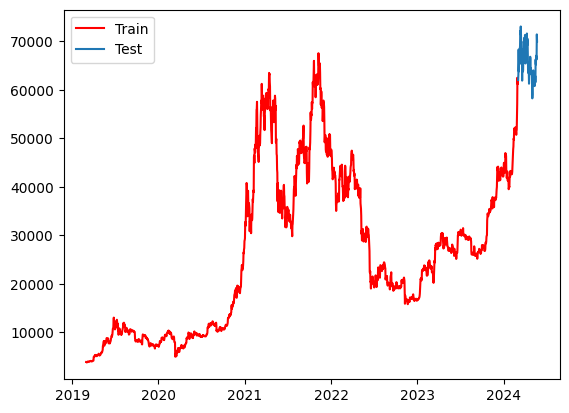

In [18]:
plt.figure()
plt.plot(pd.DataFrame(df_train).index.to_list(), pd.DataFrame(df_train['Close']), color='red', label='Train')
plt.plot(pd.DataFrame(df_test).index.to_list(),pd.DataFrame(df_test['Close']), label ='Test')
plt.legend()
plt.show()

In [19]:
scaler = MinMaxScaler(feature_range=(0, 1))
df_train_scaled = scaler.fit_transform(df_train)
df_test_scaled = scaler.transform(df_test)

df_train_scaled = pd.DataFrame(df_train_scaled, index=df_train.index, columns=df_train.columns)
df_test_scaled = pd.DataFrame(df_test_scaled, index=df_test.index, columns=df_test.columns)

In [20]:
X_train_flat = df_train_scaled.drop(columns=['Close'])
y_train_flat = df_train_scaled['Close']
X_test_flat = df_test_scaled.drop(columns=['Close'])
y_test_flat = df_test_scaled['Close']

In [21]:
print('X_train_flat shape: ',X_train_flat.shape)
print('y_train_flat shape: ',y_train_flat.shape)
print('X_test_flat shape: ',X_test_flat.shape)
print('y_test_flat shape: ',y_test_flat.shape)

X_train_flat shape:  (1828, 8)
y_train_flat shape:  (1828,)
X_test_flat shape:  (81, 8)
y_test_flat shape:  (81,)


In [22]:
def train_test_split(X_train, y_train,X_test,y_test,test_size, window_size=10):
    if window_size is not None:
        X_train = np.array([X_train[i:i+window_size] for i in range(len(X_train)-window_size)])
        y_train = y_train[window_size:]
        X_test = np.array([X_test[i:i+window_size] for i in range(len(X_test)-window_size)])
        y_test = y_test[window_size:]
    return X_train, y_train, X_test, y_test

In [23]:
X_train, y_train, X_test, y_test=train_test_split(X_train_flat,y_train_flat,X_test_flat,y_test_flat,window_size)

In [24]:
print('X_train shape: ',X_train.shape)
print('y_train shape: ',y_train.shape)
print('X_test shape: ',X_test.shape)
print('y_test shape: ',y_test.shape)

X_train shape:  (1818, 10, 8)
y_train shape:  (1818,)
X_test shape:  (71, 10, 8)
y_test shape:  (71,)


### Linear Regression ###

### GRU ###

In [25]:
def build_GRU_model(input_shape, output_size, neurons=20, activ_func='linear',
                     dropout=0.25, loss='mae', optimizer='adam'):                     
    model = Sequential()

    model.add(GRU(neurons, input_shape=input_shape))
    model.add(Dropout(dropout))
    model.add(Dense(units=output_size))
    model.add(Activation(activ_func))

    model.compile(loss=loss, optimizer=optimizer)
    return model

In [26]:
model_GRU = build_GRU_model(
    (X_train.shape[1],X_train.shape[2]), output_size=1, neurons=lstm_neurons, dropout=dropout, loss=loss,
    optimizer=optimizer)

In [27]:
history = model_GRU.fit(
    X_train, y_train, epochs=epochs, batch_size=batch_size, verbose=0, shuffle=True)

In [ ]:
model_GRU.save('model_GRU.h5')

In [28]:
pred_GRU = model_GRU.predict(X_test)
mape = mean_absolute_percentage_error(y_test, pred_GRU)
mae = mean_absolute_error(y_test,pred_GRU)
mse = mean_squared_error(y_test, pred_GRU)
print(f'Mean Absolute Percentage Error: {mape}')
print(f'Mean Absolute Error: {mae}')
print(f'Root Mean Squared Error: {math.sqrt(mse)}')

3/3 [==============================] - 2s 6ms/step
Mean Absolute Percentage Error: 0.04301974650737713
Mean Absolute Error: 0.042467141221702254
Root Mean Squared Error: 0.05019305945502559


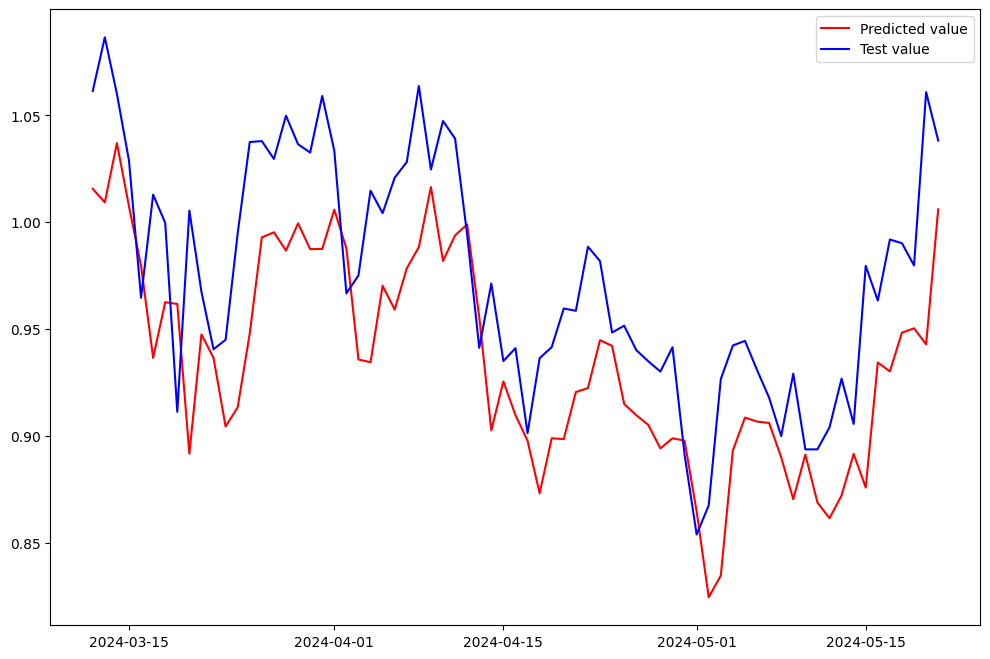

In [29]:
plt.figure(figsize=(12, 8))
plt.plot(pd.DataFrame(y_test).index.to_list(), pd.DataFrame(pred_GRU.reshape(-1)), color='red', label='Predicted value')
plt.plot(pd.DataFrame(y_test).index.to_list(), pd.DataFrame(y_test), color='blue', label='Test value')
plt.legend()
plt.show()

### RNN ###

### LSTM ###

In [31]:
def build_lstm_model(input_shape, output_size, neurons=20, activ_func='linear',
                     dropout=0.25, loss='mae', optimizer='adam'):
    model = Sequential()

    model.add(LSTM(neurons, input_shape=input_shape))
    model.add(Dropout(dropout))
    model.add(Dense(units=output_size))
    model.add(Activation(activ_func))

    model.compile(loss=loss, optimizer=optimizer)
    return model

In [32]:
model_LSTM = build_lstm_model(
    (X_train.shape[1],X_train.shape[2]), output_size=1, neurons=lstm_neurons, dropout=dropout, loss=loss,
    optimizer=optimizer)

In [33]:
history = model_LSTM.fit(
    X_train, y_train, epochs=epochs, batch_size=batch_size, verbose=0, shuffle=True)

In [34]:
model_LSTM.save('model_LSTM.h5')

In [35]:
pred_LSTM = model_LSTM.predict(X_test)
mape = mean_absolute_percentage_error(y_test, pred_LSTM)
mae = mean_absolute_error(y_test,pred_LSTM)
mse = mean_squared_error(y_test, pred_LSTM)
print(f'Mean Absolute Percentage Error: {mape}')
print(f'Mean Absolute Error: {mae}')
print(f'Root Mean Squared Error: {math.sqrt(mse)}')

3/3 [==============================] - 1s 5ms/step
Mean Absolute Percentage Error: 0.029201093158062325
Mean Absolute Error: 0.02861853122781182
Root Mean Squared Error: 0.036406185573762906


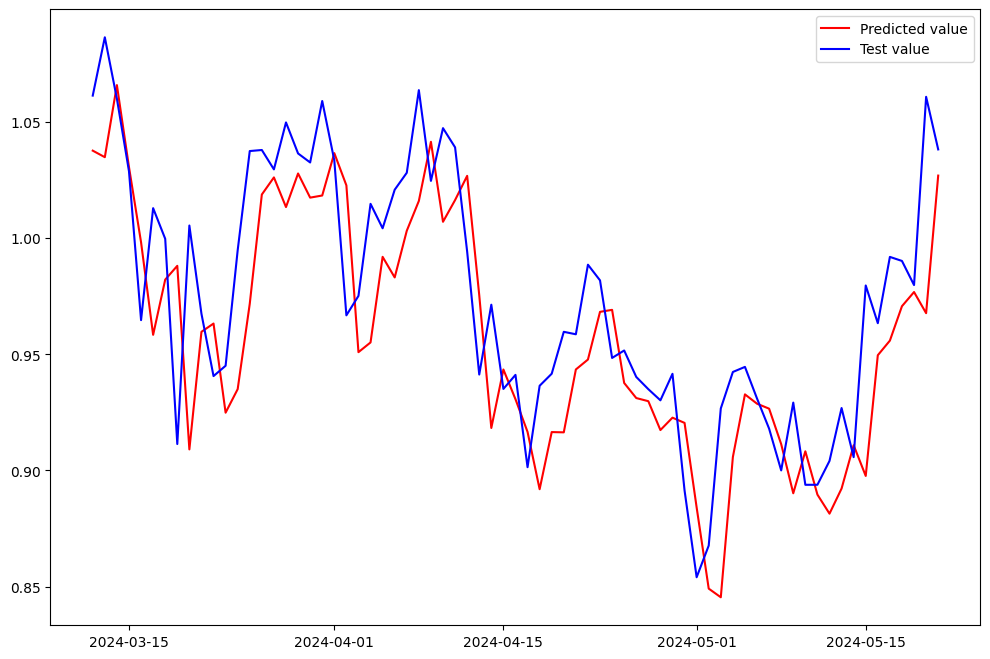

In [36]:
plt.figure(figsize=(12, 8))
plt.plot(pd.DataFrame(y_test).index.to_list(), pd.DataFrame(pred_LSTM.reshape(-1)), color='red', label='Predicted value')
plt.plot(pd.DataFrame(y_test).index.to_list(), pd.DataFrame(y_test), color='blue', label='Test value')
plt.legend()
plt.show()

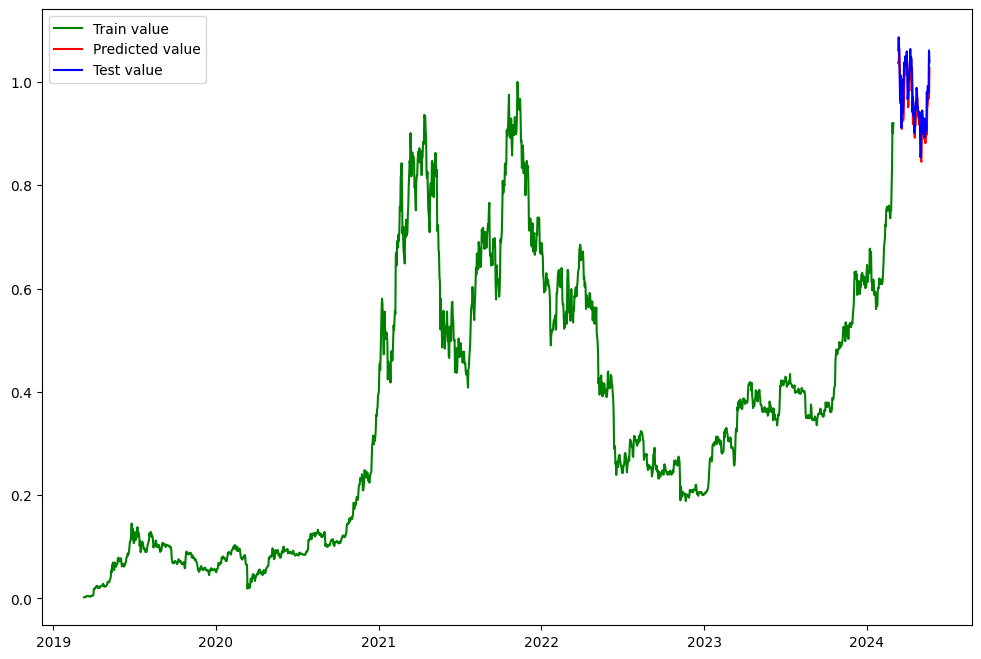

In [37]:
plt.figure(figsize=(12, 8))
plt.plot(pd.DataFrame(y_train).index.to_list(),pd.DataFrame(y_train),color='green',label='Train value')
plt.plot(pd.DataFrame(y_test).index.to_list(), pd.DataFrame(pred_LSTM.reshape(-1)), color='red', label='Predicted value')
plt.plot(pd.DataFrame(y_test).index.to_list(), pd.DataFrame(y_test), color='blue', label='Test value')
plt.legend()
plt.show()

### AUTOFORMER ###

### SARIMAX ###

### STACKING MODELS ###

In [38]:
kf = KFold(n_splits=5, shuffle=True, random_state=42)

Base model 

In [39]:
base_model_GRU = build_GRU_model(
    (X_train.shape[1],X_train.shape[2]), output_size=1, neurons=lstm_neurons, dropout=dropout, loss=loss,
    optimizer=optimizer)

In [40]:
base_model_LSTM = build_lstm_model(
    (X_train.shape[1],X_train.shape[2]), output_size=1, neurons=lstm_neurons, dropout=dropout, loss=loss,
    optimizer=optimizer)

First base model (GRU)

In [41]:
prediction_GRU_stacking = pd.DataFrame()
test_GRU_prediction={}
i=0
for train_index, test_index in kf.split(X_train):
    X_train_fold, X_test_fold = X_train[train_index], X_train[test_index]
    y_train_fold, y_test_fold = y_train[train_index], y_train[test_index]
    base_model_GRU.fit(X_train_fold, y_train_fold, epochs=10, batch_size=32, verbose=1)
    y_pred_fold = base_model_GRU.predict(X_test_fold)
    test_GRU_prediction[f'test_{i}'] = base_model_GRU.predict(X_test)
    i+=1
    y_pred_fold_df = pd.DataFrame(y_pred_fold, columns=['Prediction'])
    prediction_GRU_stacking = pd.concat([prediction_GRU_stacking, y_pred_fold_df], axis=0, ignore_index=True)

Epoch 1/10
46/46 [==============================] - 5s 12ms/step - loss: 0.2715
Epoch 2/10
46/46 [==============================] - 1s 11ms/step - loss: 0.1403
Epoch 3/10
46/46 [==============================] - 1s 11ms/step - loss: 0.0998
Epoch 4/10
46/46 [==============================] - 1s 13ms/step - loss: 0.0792
Epoch 5/10
46/46 [==============================] - 1s 14ms/step - loss: 0.0697
Epoch 6/10
46/46 [==============================] - 1s 12ms/step - loss: 0.0634
Epoch 7/10
46/46 [==============================] - 1s 11ms/step - loss: 0.0565
Epoch 8/10
46/46 [==============================] - 1s 12ms/step - loss: 0.0557
Epoch 9/10
46/46 [==============================] - 1s 12ms/step - loss: 0.0517
Epoch 10/10
3/3 [==============================] - 0s 6ms/step
Epoch 1/10
46/46 [==============================] - 0s 11ms/step - loss: 0.0467
Epoch 2/10
46/46 [==============================] - 1s 11ms/step - loss: 0.0458
Epoch 3/10
46/46 [==============================] - 1s 11

In [52]:
num_elements = len(next(iter(test_GRU_prediction.values())))
test_GRU_average = []

for i in range(num_elements):
    element_sum = sum(test_GRU_prediction[key][i] for key in test_GRU_prediction)
    test_GRU_average.append(element_sum / len(test_GRU_prediction))
test_GRU_average = pd.DataFrame(test_GRU_average)

Second base model (LSTM)

In [43]:
prediction_LSTM_stacking = pd.DataFrame()
test_LSTM_prediction={}
i=0
for train_index, test_index in kf.split(X_train):
    X_train_fold, X_test_fold = X_train[train_index], X_train[test_index]
    y_train_fold, y_test_fold = y_train[train_index], y_train[test_index]
    base_model_LSTM.fit(X_train_fold, y_train_fold, epochs=10, batch_size=32, verbose=1)
    y_pred_fold = base_model_LSTM.predict(X_test_fold)
    test_LSTM_prediction[f'test_{i}'] = base_model_LSTM.predict(X_test)
    i+=1
    y_pred_fold_df = pd.DataFrame(y_pred_fold, columns=['Prediction'])
    prediction_LSTM_stacking = pd.concat([prediction_LSTM_stacking, y_pred_fold_df], axis=0, ignore_index=True)

Epoch 1/10
46/46 [==============================] - 5s 9ms/step - loss: 0.1574
Epoch 2/10
46/46 [==============================] - 0s 9ms/step - loss: 0.0867
Epoch 3/10
46/46 [==============================] - 0s 8ms/step - loss: 0.0677
Epoch 4/10
46/46 [==============================] - 0s 10ms/step - loss: 0.0606
Epoch 5/10
46/46 [==============================] - 0s 9ms/step - loss: 0.0562
Epoch 6/10
46/46 [==============================] - 0s 9ms/step - loss: 0.0513
Epoch 7/10
46/46 [==============================] - 0s 8ms/step - loss: 0.0489
Epoch 8/10
46/46 [==============================] - 0s 8ms/step - loss: 0.0463
Epoch 9/10
46/46 [==============================] - 0s 9ms/step - loss: 0.0458
Epoch 10/10
3/3 [==============================] - 0s 7ms/step
Epoch 1/10
46/46 [==============================] - 1s 12ms/step - loss: 0.0409
Epoch 2/10
46/46 [==============================] - 1s 12ms/step - loss: 0.0399
Epoch 3/10
46/46 [==============================] - 1s 12ms/step 

In [51]:
num_elements = len(next(iter(test_LSTM_prediction.values())))
test_LSTM_average = []

for i in range(num_elements):
    element_sum = sum(test_LSTM_prediction[key][i] for key in test_LSTM_prediction)
    test_LSTM_average.append(element_sum / len(test_LSTM_prediction))

test_LSTM_average = pd.DataFrame(test_LSTM_average)

Train dataset for meta model

In [47]:
train_meta = pd.concat([prediction_LSTM_stacking, prediction_GRU_stacking], axis=1, ignore_index=True)

Test dataset for meta model

In [53]:
test_meta = pd.concat([test_LSTM_average,test_GRU_average],axis=1, ignore_index=True)

### ARIMA ###